# 03 - Evaluate on Test (July–Dec 2024)
Evaluate saved models on held-out test data with +3h horizon targets and engineered features.


In [12]:
from pathlib import Path
import sys
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, f1_score, roc_auc_score, confusion_matrix

sns.set_theme(style='whitegrid')
pd.set_option('display.max_columns', None)

PROJECT_ROOT = Path.cwd().resolve().parents[0]
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))
print('Project root:', PROJECT_ROOT)


Project root: /Users/faisalimran/Desktop/ML_PROJ/smogguard_pk


In [2]:
# Load saved models and metadata
reg_pipeline = joblib.load(PROJECT_ROOT / 'models' / 'regressor_random_forest.pkl')
clf_pipeline = joblib.load(PROJECT_ROOT / 'models' / 'classifier_random_forest.pkl')
metadata_path = PROJECT_ROOT / 'models' / 'metadata.json'
if metadata_path.exists():
    metadata = json.loads(metadata_path.read_text())
else:
    metadata = {}
print('Loaded models. Metadata keys:', list(metadata.keys()))


Loaded models. Metadata keys: ['model_version', 'horizon_hours', 'feature_columns', 'train_period', 'val_period', 'train_rows', 'val_rows', 'regression_metrics', 'classification_metrics']


In [3]:
# Load and combine test CSVs
TEST_DIR = PROJECT_ROOT / 'data' / 'raw' / 'testing'
city_files = {
    'Islamabad': 'islamabad_complete_data_testing_july_to_dec_2024.csv',
    'Lahore': 'lahore_complete_data_testing_july_to_dec_2024.csv',
    'Karachi': 'karachi_complete_data_testing_july_to_dec_2024.csv',
    'Peshawar': 'peshawar_complete_data_testing_july_to_dec_2024.csv',
    'Quetta': 'quetta_complete_data_testing_july_to_dec_2024.csv',
}
frames = []
for city, fname in city_files.items():
    path = TEST_DIR / fname
    if not path.exists():
        raise FileNotFoundError(f'Missing test file for {city}: {path}')
    df_city = pd.read_csv(path)
    df_city = df_city.rename(columns={c: c.replace('.', '_') for c in df_city.columns})
    df_city['city'] = city
    df_city['datetime'] = pd.to_datetime(df_city['datetime'], errors='coerce', dayfirst=True, format='mixed')
    df_city = df_city.dropna(subset=['datetime'])
    df_city['datetime'] = df_city['datetime'].dt.tz_localize(None)
    frames.append(df_city)

df_test = pd.concat(frames, ignore_index=True)
df_test = df_test.sort_values(['city', 'datetime']).reset_index(drop=True)
print('Test shape (raw):', df_test.shape)
display(df_test.head())


Test shape (raw): (21792, 19)


,datetime,main_aqi,components_co,components_no,components_no2,components_o3,components_so2,components_pm2_5,components_pm10,components_nh3,temperature_2m,relative_humidity_2m,dew_point_2m,precipitation,surface_pressure,wind_speed_10m,wind_direction_10m,shortwave_radiation,city
0,2024-07-01 00:00:00,3,747.68,0.00,7.63,98.71,5.78,48.03,53.20,8.99,27.779001,77.010740,23.379002,0.1,939.60760,15.379206,106.313930,0,Islamabad
1,2024-07-01 01:00:00,3,801.09,0.01,9.94,91.55,5.30,48.77,53.33,8.87,27.829000,77.717940,23.579000,0.1,939.05145,7.695920,100.784256,18,Islamabad
2,2024-07-01 02:00:00,3,988.01,0.48,20.39,79.39,6.38,49.33,53.77,10.13,28.779001,75.556970,24.029001,0.0,939.32043,8.396570,120.963690,107,Islamabad
3,2024-07-01 03:00:00,3,1295.09,2.88,33.24,77.25,9.18,49.95,54.29,11.27,30.979000,63.636982,23.279001,0.0,939.72125,5.771239,93.576260,275,Islamabad
4,2024-07-01 04:00:00,3,1121.52,2.43,23.99,120.16,15.14,42.27,46.51,9.25,32.679000,58.315285,23.429000,0.0,939.93270,3.096837,234.462230,446,Islamabad


In [6]:
# Add future targets (+3h) for test data in the format build_features expects

HORIZON_HOURS = 3  # same as in train_model.py

# Work on a sorted copy
df_test_targets = df_test.copy()
df_test_targets = df_test_targets.sort_values(["city", "datetime"]).reset_index(drop=True)

# Future AQI: main_aqi_t_plus_h (3 hours ahead per city)
df_test_targets["main_aqi_t_plus_h"] = (
    df_test_targets.groupby("city")["main_aqi"].shift(-HORIZON_HOURS)
)

# Drop rows where we don't know the future AQI (at the end of each city's series)
df_test_targets = df_test_targets[df_test_targets["main_aqi_t_plus_h"].notna()].copy()

# Future hazard label: 1 if future AQI >= 4 else 0
df_test_targets["hazard_t_plus_h"] = (df_test_targets["main_aqi_t_plus_h"] >= 4).astype(int)

print("Test targets shape:", df_test_targets.shape)
df_test_targets[["city", "datetime", "main_aqi", "main_aqi_t_plus_h", "hazard_t_plus_h"]].head()


Test targets shape: (21777, 21)


,city,datetime,main_aqi,main_aqi_t_plus_h,hazard_t_plus_h
0,Islamabad,2024-07-01 00:00:00,3,3.0,0
1,Islamabad,2024-07-01 01:00:00,3,3.0,0
2,Islamabad,2024-07-01 02:00:00,3,4.0,1
3,Islamabad,2024-07-01 03:00:00,3,5.0,1
4,Islamabad,2024-07-01 04:00:00,3,4.0,1


In [4]:
# Add future targets (+3h)
from src.features.targets import add_future_targets

df_test_targets = add_future_targets(df_test, horizon_hours=3)
df_test_targets = df_test_targets.rename(columns={
    'main_aqi_t_plus_h': 'main_aqi_t_plus_3',
    'hazard_t_plus_h': 'hazard_t_plus_3',
})
print('Test shape with targets:', df_test_targets.shape)
display(df_test_targets[['datetime', 'city', 'main_aqi', 'main_aqi_t_plus_3', 'hazard_t_plus_3']].head())


Test shape with targets: (21777, 21)


,datetime,city,main_aqi,main_aqi_t_plus_3,hazard_t_plus_3
0,2024-07-01 00:00:00,Islamabad,3,3.0,0
1,2024-07-01 01:00:00,Islamabad,3,3.0,0
2,2024-07-01 02:00:00,Islamabad,3,4.0,1
3,2024-07-01 03:00:00,Islamabad,3,5.0,1
4,2024-07-01 04:00:00,Islamabad,3,4.0,1


In [7]:
# Build features on test data
from src.features.build_features import build_features

df_test_features = build_features(df_test_targets)
print('Test shape with engineered features:', df_test_features.shape)
display(df_test_features.head())


Test shape with engineered features: (21762, 36)


,datetime,main_aqi,components_co,components_no,components_no2,components_o3,components_so2,components_pm2_5,components_pm10,components_nh3,temperature_2m,relative_humidity_2m,dew_point_2m,precipitation,surface_pressure,wind_speed_10m,wind_direction_10m,shortwave_radiation,city,main_aqi_t_plus_h,hazard_t_plus_h,hour,dayofweek,month,is_weekend,main_aqi_lag_1,main_aqi_lag_2,main_aqi_lag_3,components_pm2_5_lag_1,components_pm2_5_lag_2,components_pm2_5_lag_3,components_pm10_lag_1,components_pm10_lag_2,components_pm10_lag_3,components_pm2_5_roll3_mean,components_pm10_roll3_mean
3,2024-07-01 03:00:00,3,1295.09,2.88,33.24,77.25,9.18,49.95,54.29,11.27,30.979,63.636982,23.279001,0.0,939.72125,5.771239,93.57626,275,Islamabad,5.0,1,3,0,7,0,3.0,3.0,3.0,49.33,48.77,48.03,53.77,53.33,53.20,49.350000,53.796667
4,2024-07-01 04:00:00,3,1121.52,2.43,23.99,120.16,15.14,42.27,46.51,9.25,32.679,58.315285,23.429000,0.0,939.93270,3.096837,234.46223,446,Islamabad,4.0,1,4,0,7,0,3.0,3.0,3.0,49.95,49.33,48.77,54.29,53.77,53.33,47.183333,51.523333
5,2024-07-01 05:00:00,4,947.95,1.45,14.39,163.08,16.21,39.44,43.52,8.23,33.679,56.306350,23.779001,0.0,939.54517,7.517021,253.30067,609,Islamabad,4.0,1,5,0,7,0,3.0,3.0,3.0,42.27,49.95,49.33,46.51,54.29,53.77,43.886667,48.106667
6,2024-07-01 06:00:00,5,821.11,0.79,8.14,191.69,16.21,37.23,40.90,7.54,34.479,54.336906,23.929000,0.0,939.21510,8.287822,272.48950,734,Islamabad,4.0,1,6,0,7,0,4.0,3.0,3.0,39.44,42.27,49.95,43.52,46.51,54.29,39.646667,43.643333
7,2024-07-01 07:00:00,4,640.87,0.47,4.37,171.66,10.73,30.65,36.66,6.40,35.429,50.780220,23.679000,0.0,938.43896,7.993298,277.76508,814,Islamabad,4.0,1,7,0,7,0,5.0,4.0,3.0,37.23,39.44,42.27,40.90,43.52,46.51,35.773333,40.360000


In [9]:
# Feature columns and targets
default_feature_columns = [
    'main_aqi', 'components_co', 'components_no', 'components_no2', 'components_o3', 'components_so2',
    'components_pm2_5', 'components_pm10', 'components_nh3', 'temperature_2m', 'relative_humidity_2m',
    'dew_point_2m', 'precipitation', 'surface_pressure', 'wind_speed_10m', 'wind_direction_10m',
    'shortwave_radiation', 'city',
    'hour', 'dayofweek', 'month', 'is_weekend',
    'main_aqi_lag_1', 'main_aqi_lag_2', 'main_aqi_lag_3',
    'components_pm2_5_lag_1', 'components_pm2_5_lag_2', 'components_pm2_5_lag_3',
    'components_pm10_lag_1', 'components_pm10_lag_2', 'components_pm10_lag_3',
    'components_pm2_5_roll3_mean', 'components_pm10_roll3_mean',
]
feature_columns = metadata.get('feature_columns', default_feature_columns)
missing = [c for c in feature_columns if c not in df_test_features.columns]
if missing:
    raise ValueError(f'Missing expected feature columns on test set: {missing}')

X_test = df_test_features[feature_columns]
y_test_reg = df_test_features['main_aqi_t_plus_h']
y_test_clf = df_test_features['hazard_t_plus_h']

print('X_test shape:', X_test.shape)


X_test shape: (21762, 33)


In [13]:
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Evaluate regression model (overall)
y_pred_reg = reg_pipeline.predict(X_test)

mse = mean_squared_error(y_test_reg, y_pred_reg)
rmse = sqrt(mse)              # no squared=False
mae = mean_absolute_error(y_test_reg, y_pred_reg)
r2 = r2_score(y_test_reg, y_pred_reg)

print('Regression metrics (overall):')
print('MSE:', mse)
print('RMSE:', rmse)
print('MAE:', mae)
print('R^2:', r2)

# Per-city metrics
rows = []
for city, group in df_test_features.groupby('city'):
    y_true_c = group['main_aqi_t_plus_h']   # use correct column name
    X_c = group[feature_columns]
    y_pred_c = reg_pipeline.predict(X_c)

    mse_c = mean_squared_error(y_true_c, y_pred_c)
    rmse_c = sqrt(mse_c)
    mae_c = mean_absolute_error(y_true_c, y_pred_c)
    r2_c = r2_score(y_true_c, y_pred_c)

    rows.append({
        'city': city,
        'rmse': rmse_c,
        'mae': mae_c,
        'r2': r2_c,
    })

reg_city_df = pd.DataFrame(rows)
display(reg_city_df)


Regression metrics (overall):
MSE: 0.21585863431669883
RMSE: 0.46460589139258535
MAE: 0.3053506111570628
R^2: 0.8168652044889098


,city,rmse,mae,r2
0,Islamabad,0.480609,0.312707,0.751050
1,Karachi,0.482132,0.333014,0.824768
2,Lahore,0.400595,0.230491,0.724438
3,Peshawar,0.466260,0.292703,0.764105
4,Quetta,0.488055,0.358281,0.715460


In [15]:
# Evaluate classification model
y_pred_clf = clf_pipeline.predict(X_test)
if hasattr(clf_pipeline, 'predict_proba'):
    proba = clf_pipeline.predict_proba(X_test)
    y_proba = proba[:, 1] if proba.shape[1] > 1 else None
else:
    y_proba = None

acc = accuracy_score(y_test_clf, y_pred_clf)
f1 = f1_score(y_test_clf, y_pred_clf, zero_division=0)
roc = roc_auc_score(y_test_clf, y_proba) if y_proba is not None else None
cm = confusion_matrix(y_test_clf, y_pred_clf)

print('Classification metrics (overall):')
print('Accuracy:', acc)
print('F1:', f1)
print('ROC-AUC:', roc)
print('Confusion matrix:', cm)

rows = []
for city, group in df_test_features.groupby('city'):
    y_true_c = group['hazard_t_plus_h']
    y_pred_c = clf_pipeline.predict(group[feature_columns])
    rows.append({
        'city': city,
        'accuracy': accuracy_score(y_true_c, y_pred_c),
        'f1': f1_score(y_true_c, y_pred_c, zero_division=0),
    })
clf_city_df = pd.DataFrame(rows)
display(clf_city_df)


Classification metrics (overall):
Accuracy: 0.9042826946052752
F1: 0.9288082299463413
ROC-AUC: 0.9678310609190398
Confusion matrix: [[ 6091  1529]
 [  554 13588]]


,city,accuracy,f1
0,Islamabad,0.902109,0.940104
1,Karachi,0.910097,0.908579
2,Lahore,0.941082,0.966920
3,Peshawar,0.897295,0.933728
4,Quetta,0.870678,0.831784


/var/folders/9b/ft46xt2x2yv14x6v95ddt9kw0000gn/T/ipykernel_84516/1395592993.py:6: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  sample_week = sample.last('7D')


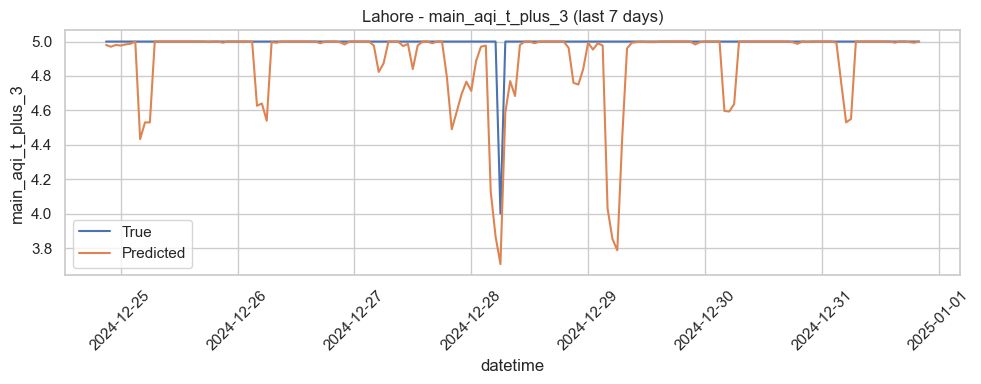

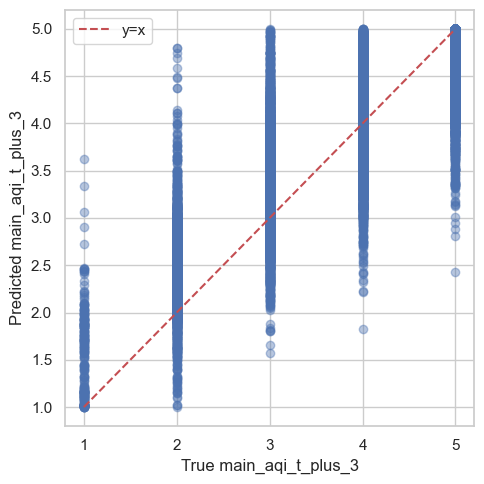

In [17]:
# Plots
# Time series for Lahore over a sample week
lahore = df_test_features[df_test_features['city'] == 'Lahore'].copy()
if not lahore.empty:
    sample = lahore.sort_values('datetime').set_index('datetime')
    sample_week = sample.last('7D')
    plt.figure(figsize=(10,4))
    plt.plot(sample_week.index, sample_week['main_aqi_t_plus_h'], label='True')
    plt.plot(sample_week.index, reg_pipeline.predict(sample_week[feature_columns]), label='Predicted')
    plt.title('Lahore - main_aqi_t_plus_3 (last 7 days)')
    plt.xlabel('datetime')
    plt.ylabel('main_aqi_t_plus_3')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Scatter plot of true vs predicted
plt.figure(figsize=(5,5))
plt.scatter(y_test_reg, y_pred_reg, alpha=0.4)
lims = [min(y_test_reg.min(), y_pred_reg.min()), max(y_test_reg.max(), y_pred_reg.max())]
plt.plot(lims, lims, 'r--', label='y=x')
plt.xlabel('True main_aqi_t_plus_3')
plt.ylabel('Predicted main_aqi_t_plus_3')
plt.legend()
plt.tight_layout()
plt.show()
